In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 15.9 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from tqdm import tqdm
import resampy

In [3]:
def create_dataset_df(csv_file):
    dataset_df = pd.read_csv(csv_file)
    filepaths = []
    for i, row in dataset_df.iterrows():
        filepaths.append(os.path.join('/content/drive/MyDrive/ThesisData/', 'File'+str(row['fold']), row['slice_file_name']))
    dataset_df['filepath'] = filepaths
    return dataset_df

In [4]:
df = create_dataset_df('/content/drive/MyDrive/ThesisData/ThesisLionMD.csv')
df.head()

,fs_id,slice_file_name,classID,fold,class,filepath
0,iroar_123,iroar_123.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...
1,iroar_308,iroar_308.wav,1,1,IRoar,/content/drive/MyDrive/ThesisData/File1/iroar_...
2,grunt_878,grunt_878.wav,2,2,Grunt,/content/drive/MyDrive/ThesisData/File2/grunt_...
3,roar_178,roar_178.wav,0,1,Roar,/content/drive/MyDrive/ThesisData/File1/roar_1...
4,roar_963,roar_963.wav,0,3,Roar,/content/drive/MyDrive/ThesisData/File3/roar_9...


In [5]:
class_map = {'1' : 'IRoar', '0' : 'Roar', '2' : 'Grunt'}
pd.DataFrame(sorted(list(class_map.items())))

,0,1
0,0,Roar
1,1,IRoar
2,2,Grunt


In [6]:
appended = []
for i in range(1,4):
    appended.append(df[df.fold == i]['class'].value_counts())

class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,4)]
class_distribution

,index,Grunt,Roar,IRoar
0,fold1,496,333,329
1,fold2,496,331,330
2,fold3,499,333,333


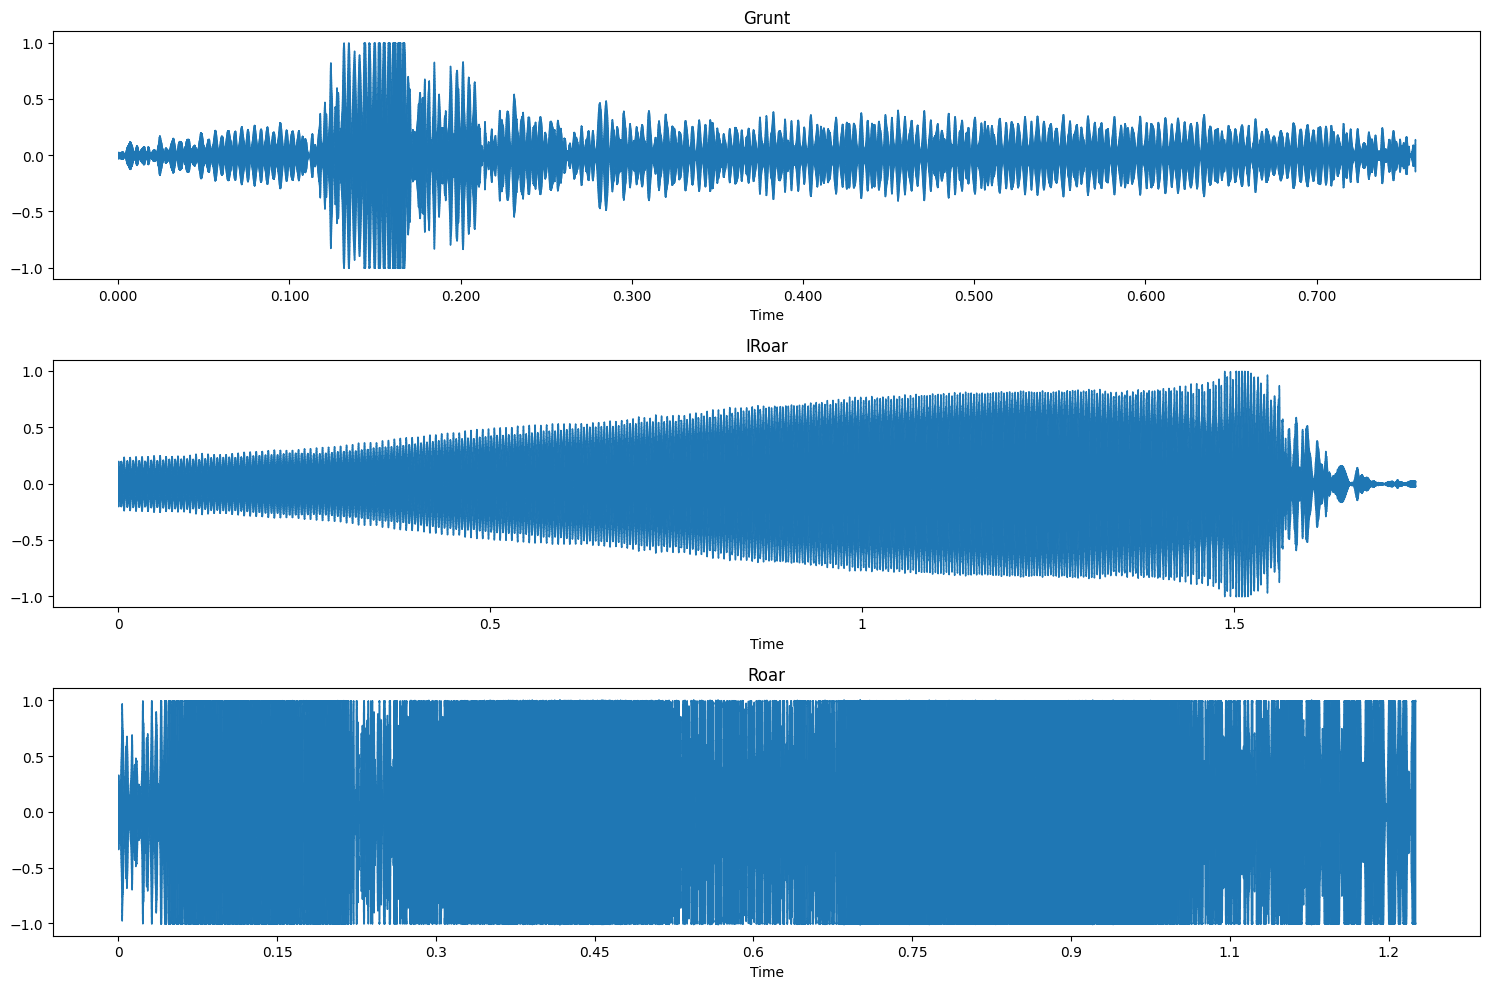

In [7]:
# Randomly select one sample of each class
random_samples = df.groupby('class').sample(1)
audio_samples, labels = random_samples['filepath'].tolist(), random_samples['class'].tolist()

# Visualize the waveforms
fig, axs = plt.subplots(3, 1, figsize=(15,10))
index = 0
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    librosa.display.waveshow(y=audio_file, sr=sample_rate, ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

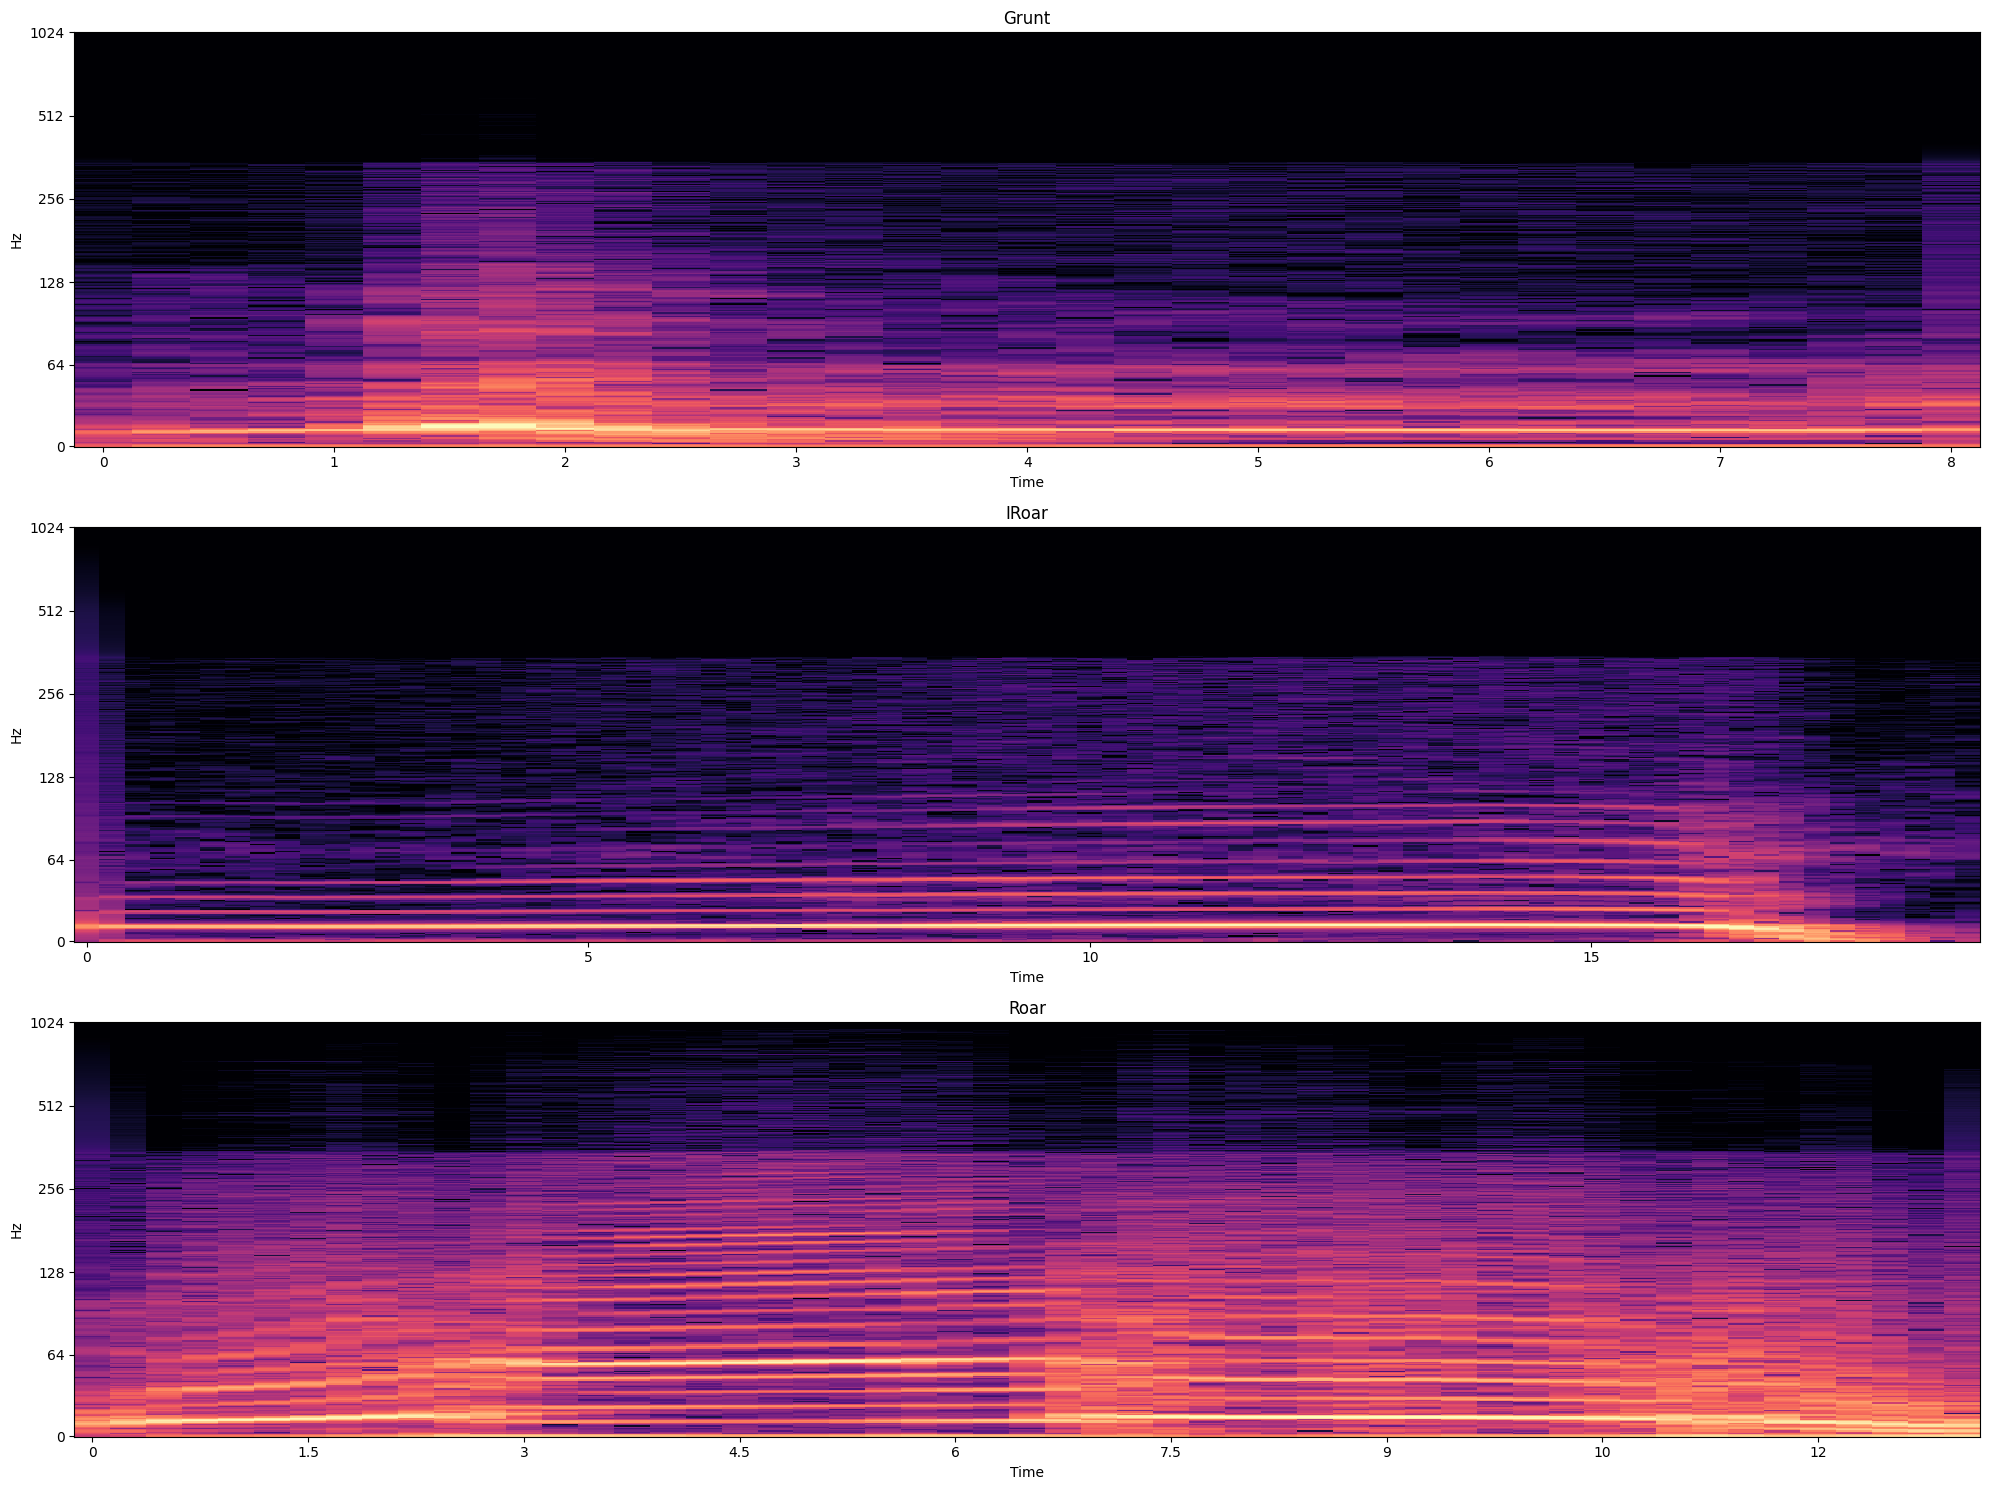

In [8]:
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(3, 1, figsize=(20,15))
index = 0
n_s = 4
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    stft = librosa.stft(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    librosa.display.specshow(S_db,
                         sr=n_fft,
                         hop_length=hop_length,
                         x_axis="time",
                         y_axis='log',
                         ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

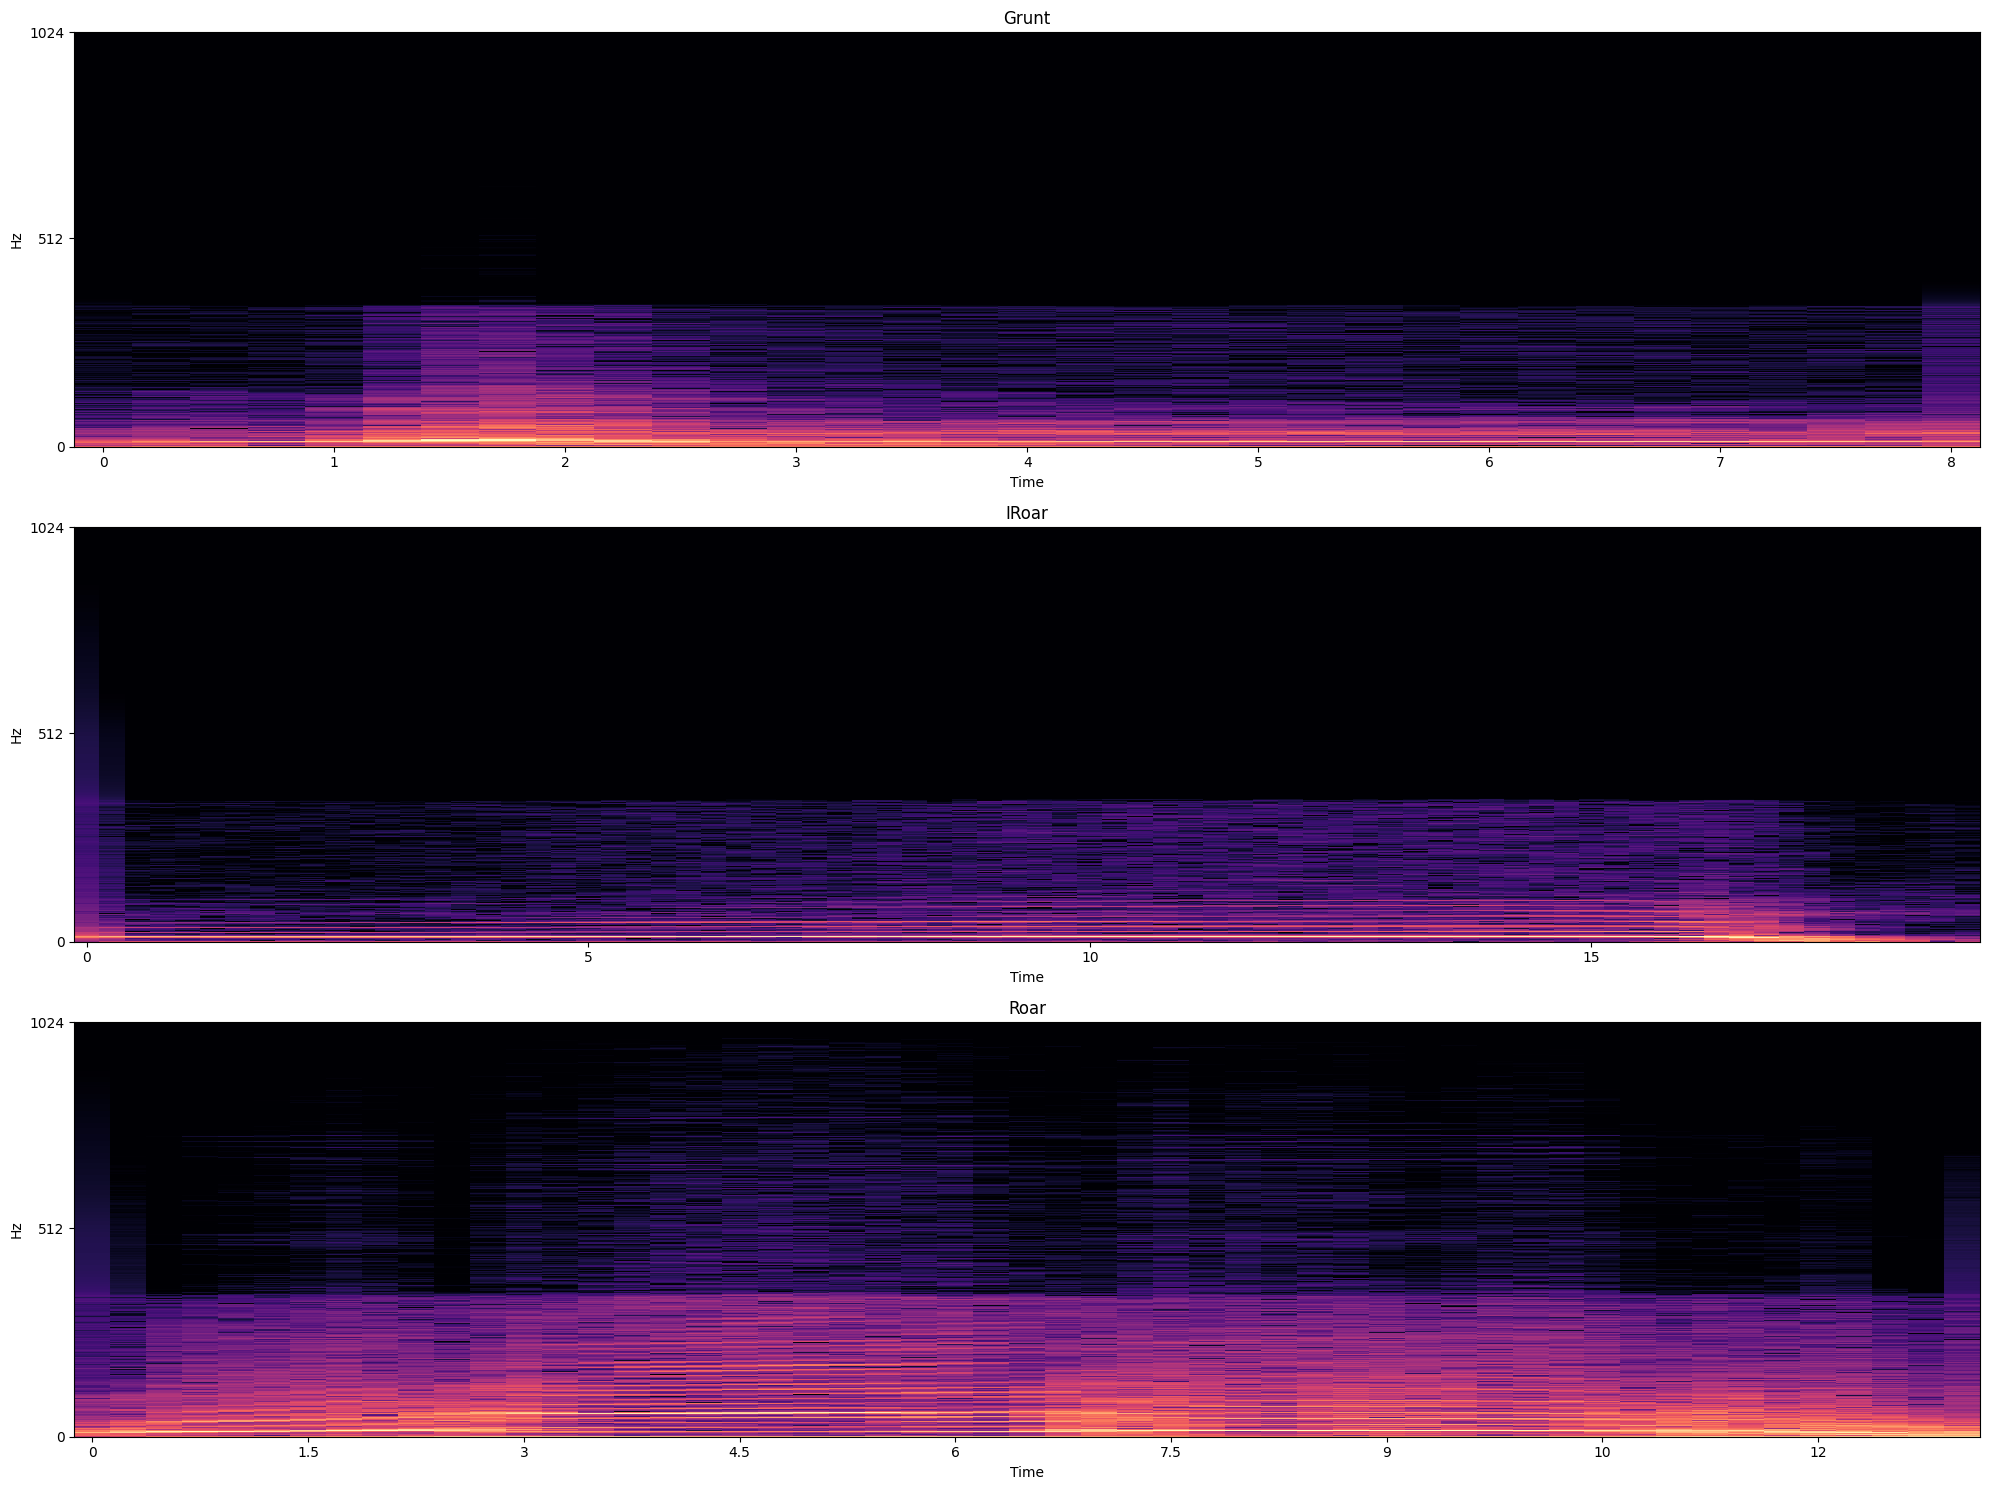

In [9]:
# Visualize the Mel-Spectograms
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(3, 1, figsize=(20,15))
index = 0
n_s = 4
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    stft = librosa.stft(y=audio_file, n_fft=n_fft, hop_length=hop_length)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    librosa.display.specshow(S_db,
                         sr=n_fft,
                         hop_length=hop_length,
                         x_axis="time",
                         y_axis='mel',
                         ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

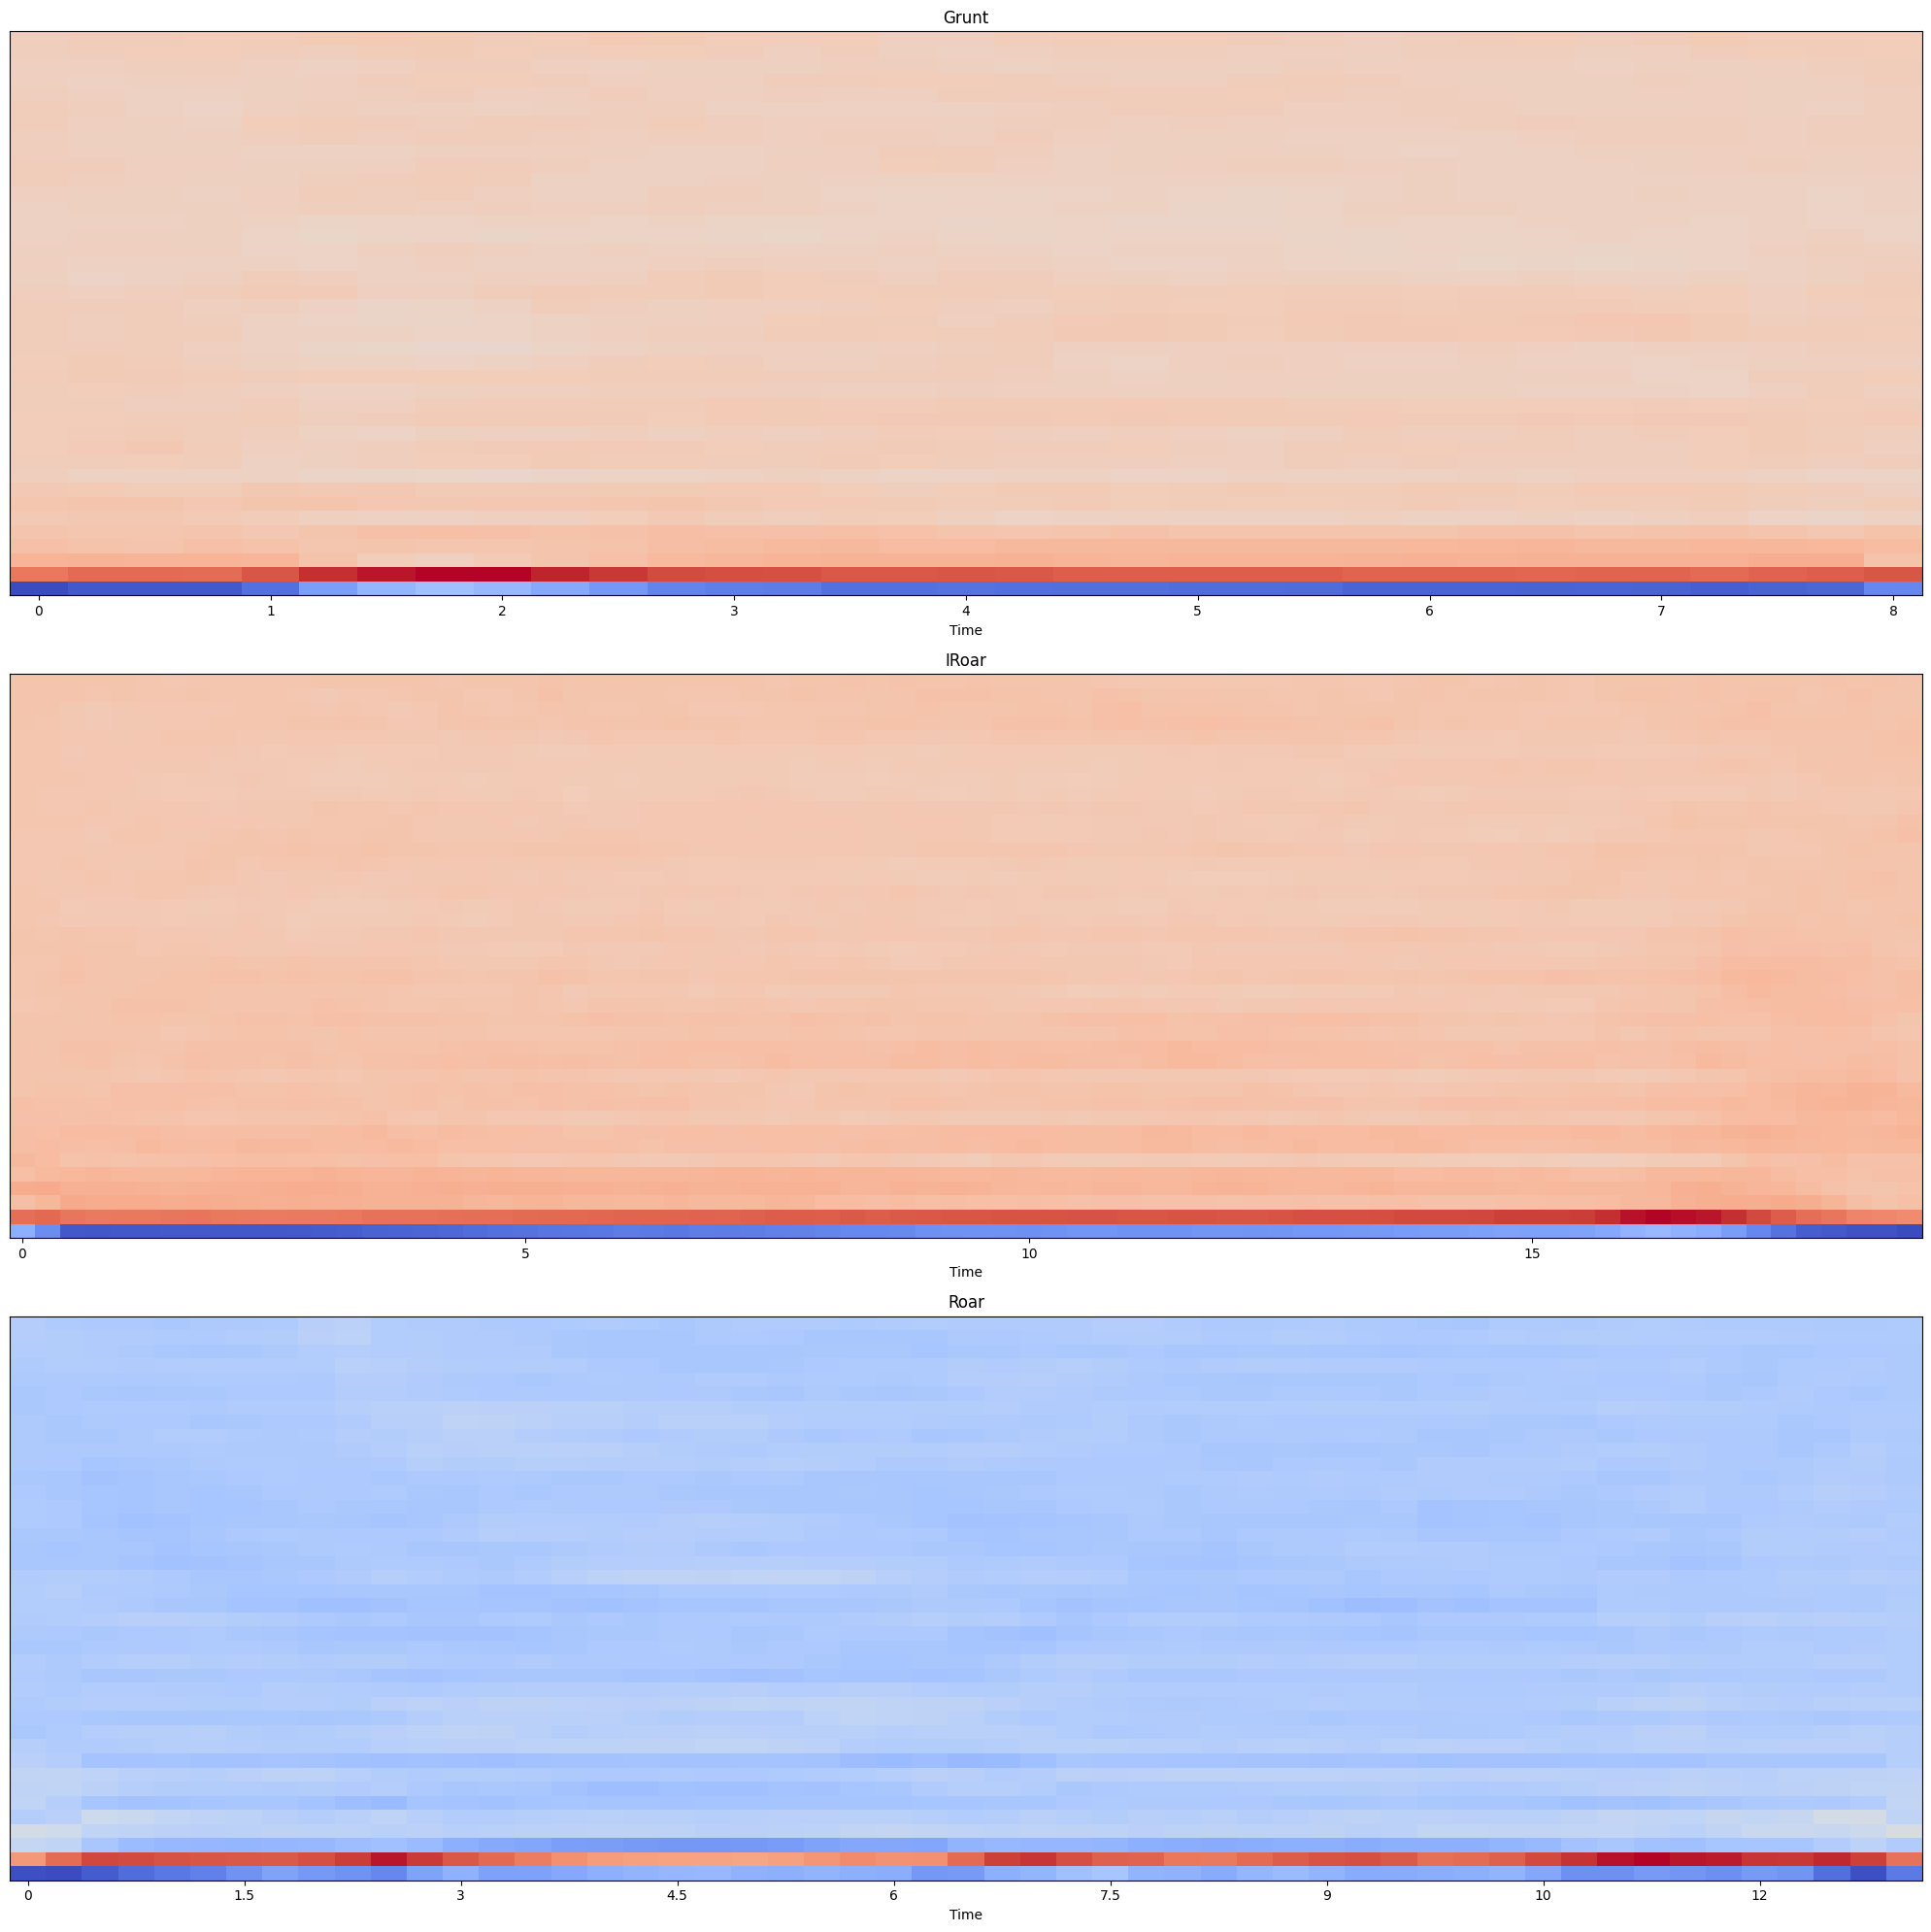

In [10]:
# Visualize 40 MFCCs
n_fft = 2048
# Librosa default is n_fft // 4
hop_length = 512
fig, axs = plt.subplots(3, 1, figsize=(20,20))
index = 0
n_s = 4
for col in range(3):
    audio_file, sample_rate = librosa.load(audio_samples[index])
    mfccs = librosa.feature.mfcc(y=audio_file,
                                sr=sample_rate,
                                n_fft=n_fft,
                                n_mfcc=40)
    librosa.display.specshow(mfccs,
                         sr=n_fft,
                         hop_length=hop_length,
                         x_axis="time",
                         ax=axs[col])
    axs[col].set_title('{}'.format(labels[index]))
    index += 1
fig.tight_layout()

In [11]:
# Feature extraction using librosa

def features_extract(file):
    # load the audio file
    audio,sample_rate = librosa.load(file_name,res_type='kaiser_fast')

    # extract the features
    feature = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
    feature_norm = (feature - feature.mean())/feature.std()

    # feature scaling
    scaled_feature = np.mean(feature_norm.T,axis=0)

    # return the scaled features
    return scaled_feature

# list containg all the features
extracted = []

# for each row in the csv
for index_num,row in tqdm(df.iterrows()):

    # get the file
    file_name = os.path.join(os.path.abspath('drive/MyDrive/ThesisData/'),'File'+str(row["fold"])+'/',str(row['slice_file_name']))

    # get file label
    final_class_labels = row['class']

    # extract feature
    data= features_extract(file_name)

    # store it in a list
    extracted.append([data,final_class_labels])

177it [01:18,  2.32it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1999
  warnings.warn(
3480it [24:34,  2.36it/s]


In [12]:
df_extracted = pd.DataFrame(extracted,columns=['feature','label'])

# Adding 'fold' column to new DataFrame which contains extracted feature and label
df_extracted['fold'] = df['fold']
df_extracted.head()

,feature,label,fold
0,"[-2.6851103, 4.9215136, -0.5920793, 0.33658698...",IRoar,1
1,"[-1.300043, 5.764561, -0.92583525, 0.32385802,...",IRoar,1
2,"[-3.4854968, 4.821215, 0.21906464, 0.5061829, ...",Grunt,2
3,"[-3.293087, 4.9144835, -0.10125761, 0.33404773...",Roar,1
4,"[-2.1113944, 5.5521727, -0.5898474, 0.36284083...",Roar,3


In [13]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [14]:
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense , Activation , Dropout

In [15]:
le = LabelEncoder()
y = np.array(df_extracted.label.tolist())

filter_size = 3
y = np_utils.to_categorical(le.fit_transform(y))

num_labels = y.shape[1]

# build model
model = Sequential()
model.add(Dense(512, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               20992     
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 activation_1 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [16]:
predicted = []
actual = []

# Taking 1 fold for Validation and rest 9 folds for train sets.
# Using for loop so that each fold becomes validation set once and rest 9 as train set.

for i in range(1,4):
    validation_data = df_extracted[df_extracted['fold'] == i]
    train_data = df_extracted[df_extracted['fold'] != i]

    x = np.array(train_data.feature.tolist())
    y = np.array(train_data.label.tolist())

    x_val = np.array(validation_data.feature.tolist())
    y_val = np.array(validation_data.label.tolist())

    y = np_utils.to_categorical(le.fit_transform(y))
    y_val = np_utils.to_categorical(le.fit_transform(y_val))

    fitting = model.fit(x, y, batch_size=64, epochs=10, validation_data=(x_val, y_val), shuffle=False)
    pred = model.predict(x_val)

    predicted.append(pred)
    actual.append(y_val)

Epoch 1/10
37/37 [==============================] - 2s 17ms/step - loss: 0.8305 - accuracy: 0.6197 - val_loss: 0.6351 - val_accuracy: 0.7263
Epoch 2/10
37/37 [==============================] - 0s 9ms/step - loss: 0.5531 - accuracy: 0.7666 - val_loss: 0.5451 - val_accuracy: 0.7634
Epoch 3/10
37/37 [==============================] - 0s 10ms/step - loss: 0.5054 - accuracy: 0.7898 - val_loss: 0.5339 - val_accuracy: 0.7686
Epoch 4/10
37/37 [==============================] - 0s 10ms/step - loss: 0.4754 - accuracy: 0.8062 - val_loss: 0.5433 - val_accuracy: 0.7686
Epoch 5/10
37/37 [==============================] - 0s 10ms/step - loss: 0.4560 - accuracy: 0.8075 - val_loss: 0.5088 - val_accuracy: 0.7737
Epoch 6/10
37/37 [==============================] - 0s 11ms/step - loss: 0.4496 - accuracy: 0.8165 - val_loss: 0.5216 - val_accuracy: 0.7660
Epoch 7/10
37/37 [==============================] - 0s 10ms/step - loss: 0.4362 - accuracy: 0.8299 - val_loss: 0.5346 - val_accuracy: 0.7703
Epoch 8/10
37/

In [17]:
from sklearn.metrics import accuracy_score

In [21]:
acc = []
for i in range(0,3):
    predict_conv = np.argmax(predicted[i],axis=1)
    actual_conv = np.argmax(actual[i],axis=1)
    acc.append(accuracy_score(actual_conv,predict_conv))
print("Accuracy for 3 fold cross validation:",np.mean(acc))

Accuracy for 3 fold cross validation: 0.8005968923004904


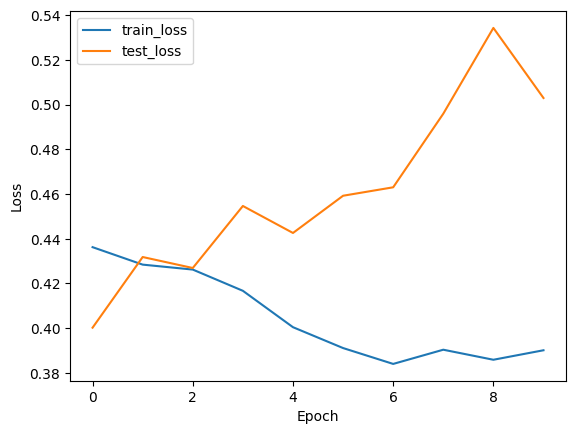

In [22]:
# Plotting ANN Loss

metrics = fitting.history
plt.plot(fitting.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

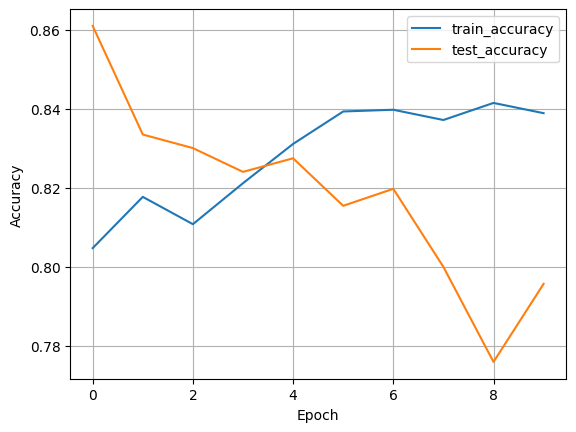

In [23]:
# Plotting ANN Accuracy

plt.plot(fitting.history['accuracy'], label='train_accuracy')
plt.plot(fitting.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)